In [1]:
#Loading All Needed Libraries

In [2]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

# #Number Manupulation & Plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# #Model Selection Libraries
# from sklearn import model_selection
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import validation_curve

# #Preprocessing Libraries
# from sklearn.preprocessing import scale
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import PolynomialFeatures

# #Liner Model Libraries
# from sklearn import linear_model
# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import Lasso
# from sklearn.linear_model import ElasticNet

# #pipeline libraries
# from sklearn.pipeline import Pipeline
# from sklearn.pipeline import make_pipeline

# #Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# import sklearn
# import sklearn.decomposition

# from sklearn.svm import SVC
# from sklearn.feature_selection import RFE

# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor

<font color=red size=6> Define Objective </font>

- Identify Hight Value Customer-HVC: Those who have recharged with an amount >= X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase)

- Identify which customers are in action phase. 3rd month usage==0
- Identify which customers are churn. 3rd month + 4th month usage==0
- Make a model to predict churn from of HVC. But use only 3 month data.
- Compare the performance of model 

1. It is a regression problem
- Make a model which has highest R-square score on test dataset. 
- At the same time R-Score score on Train dataset should be such that it can be confidently accepted by the customer

<font color=red size=6> Understanding Dataset</font>

In [3]:
#A field will be treated as categorical if Max Categories are less than number below.
#This is just a guess and it can be tuned. It is just to ease the data cleaning process and has no other value.
max_cat=200

In [4]:
target_="churn"
id_="mobile_number"

In [5]:
#Create a list of Categorical Variables. This step is useful when there are many fields in dataset
#If they are numeric in nature, convert into Object
#In final dataset all categorical variable (ordinal, nominal) will be object type

In [6]:
#Returns a list of field of particular type from dataset=df, 
#fldType : cat for categorical variables, num for numerial variables
#the return list will not include target variable name and id variable name.

def get_fld_list(df, fldType, printResults=False):
    categories = min(max_cat, int(len(df)*.5))
    fld_list = []
    for col in df.columns:
        l=len(df[col].unique())
        if fldType=="cat":
            if l<=categories:
                fld_list.append(col)
                if printResults:
                    print ("Categorical Field:",col, df[col].unique())
            else:
                if printResults:
                    print ("Excluded Fields",col,l)  
        elif fldType=="num":
            if l>categories:
                if l>categories:
                    fld_list.append(col)
                else:
                    if printResults:
                        print (col,l)
                
    if target_ in fld_list:
        fld_list.remove(target_)
    if id_ in fld_list:
        fld_list.remove(id_)
        
    return fld_list

<font color=red size=3>Understanding Field Name & Renaming them for correct standard use</font>

In [7]:
#Lad partial dataset in memory
df = pd.read_csv("telecom_churn_data.csv")

In [8]:
all_cols = list(df.columns)
rech_cols = [rech for rech in all_cols if "rech" in rech]

In [9]:
df[rech_cols].head().isna().sum()

total_rech_num_6            0
total_rech_num_7            0
total_rech_num_8            0
total_rech_num_9            0
total_rech_amt_6            0
total_rech_amt_7            0
total_rech_amt_8            0
total_rech_amt_9            0
max_rech_amt_6              0
max_rech_amt_7              0
max_rech_amt_8              0
max_rech_amt_9              0
date_of_last_rech_6         0
date_of_last_rech_7         0
date_of_last_rech_8         0
date_of_last_rech_9         0
date_of_last_rech_data_6    3
date_of_last_rech_data_7    3
date_of_last_rech_data_8    3
date_of_last_rech_data_9    4
total_rech_data_6           3
total_rech_data_7           3
total_rech_data_8           3
total_rech_data_9           4
max_rech_data_6             3
max_rech_data_7             3
max_rech_data_8             3
max_rech_data_9             4
count_rech_2g_6             3
count_rech_2g_7             3
count_rech_2g_8             3
count_rech_2g_9             4
count_rech_3g_6             3
count_rech

In [10]:
df[rech_cols].head(2)

,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,...,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
0,4,3,2,6,362,252,252,0,252,252,...,0.0,NaN,1.0,1.0,1.0,NaN,252.0,252.0,252.0,NaN
1,4,9,11,5,74,384,283,121,44,154,...,2.0,NaN,NaN,0.0,0.0,NaN,NaN,154.0,50.0,NaN


In [11]:
#create a new field for first 2 month average recharge value
df['total_rech_amt_avg'] = (df['total_rech_amt_6'] + df['total_rech_amt_7' ])/2
#check 70 percentail of this field
df['total_rech_amt_avg'].describe(percentiles=[.7])

count    99999.000000
mean       325.238792
std        370.833466
min          0.000000
50%        229.000000
70%        368.500000
max      37762.500000
Name: total_rech_amt_avg, dtype: float64

In [12]:
rech_val70 = df['total_rech_amt_avg'].describe(percentiles=[.7])[5]
#keep only high value customer in dataset
df = df[ df['total_rech_amt_avg']>=rech_val70 ]

In [13]:
df.shape

(30011, 227)

In [14]:
#Flag those customer which are churn
df['churn'] = df['total_ic_mou_9']+df['total_og_mou_9']+df['vol_2g_mb_9']+df['vol_3g_mb_9']==0
df['churn'] = df.churn.apply(lambda x: 1 if x==True else 0)
df['churn'][0:10]

7     1
8     0
13    0
16    0
17    0
21    0
24    0
33    0
38    0
41    0
Name: churn, dtype: int64

In [15]:
#correct name of columns
df[['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6', 'vbc_3g_9']] = df[['aug_vbc_3g','jul_vbc_3g','jun_vbc_3g','sep_vbc_3g']]
df.drop(columns=['aug_vbc_3g','jul_vbc_3g','jun_vbc_3g','sep_vbc_3g'], inplace=True)

In [16]:
#Remove those columns which contains 9th month data
all_cols=df.columns
cols_9 = [rech for rech in all_cols if "_9" in rech]
print (cols_9)

df.drop(columns=cols_9, inplace=True)

['last_date_of_month_9', 'arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'vbc_3g_9']


In [17]:
df['churn'].astype("category").value_counts()
#churn is 8%

0    27418
1     2593
Name: churn, dtype: int64

In [18]:
#identify those columns which has date information
all_cols= df.columns
cols_date = [c for c in all_cols if 'date_' in c]
cols_date

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [19]:
df[cols_date].head(2)

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
7,6/30/2014,7/31/2014,8/31/2014,6/27/2014,7/25/2014,8/26/2014,NaN,NaN,NaN
8,6/30/2014,7/31/2014,8/31/2014,6/25/2014,7/31/2014,8/30/2014,NaN,7/31/2014,8/23/2014


In [20]:
#Check what dates are stored
for c in cols_date:
    print ( df[c].astype("category").value_counts())

6/30/2014    30011
Name: last_date_of_month_6, dtype: int64
7/31/2014    29980
Name: last_date_of_month_7, dtype: int64
8/31/2014    29854
Name: last_date_of_month_8, dtype: int64
6/30/2014    8724
6/29/2014    5589
6/28/2014    3716
6/27/2014    3244
6/26/2014    1839
6/25/2014    1312
6/24/2014    1078
6/23/2014     707
6/21/2014     587
6/22/2014     520
6/14/2014     468
6/20/2014     353
6/19/2014     350
6/17/2014     350
6/18/2014     301
6/16/2014     170
6/12/2014     128
6/13/2014     119
6/15/2014     116
6/11/2014      72
6/8/2014       42
6/7/2014       32
6/10/2014      29
6/5/2014       20
6/9/2014       19
6/3/2014       18
6/4/2014       15
6/2/2014       12
6/1/2014       11
6/6/2014        8
Name: date_of_last_rech_6, dtype: int64
7/31/2014    7927
7/30/2014    5355
7/29/2014    3478
7/28/2014    2861
7/25/2014    2116
7/27/2014    1743
7/26/2014    1660
7/24/2014     868
7/22/2014     609
7/23/2014     564
7/16/2014     400
7/21/2014     373
7/20/2014     360
7/15/2

In [21]:
#Delete following columns because there is only one date in these column and it will not help in prediction.
df.drop(columns=['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'],inplace=True)

In [22]:
all_cols= df.columns
cols_date = [c for c in all_cols if 'date_' in c]
df[cols_date].head(2)

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
7,6/27/2014,7/25/2014,8/26/2014,NaN,NaN,NaN
8,6/25/2014,7/31/2014,8/30/2014,NaN,7/31/2014,8/23/2014


In [23]:
#extract day of the date from date column and remove month and year information. That is not useful for us.
from datetime import datetime
for col in cols_date:
    df[col] = df[col].str.split("/",expand=True)[1]
    df[col] = df[col].astype("float16")

In [24]:
df[cols_date].head(3)

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
7,27.0,25.0,26.0,NaN,NaN,NaN
8,25.0,31.0,30.0,NaN,31.0,23.0
13,20.0,22.0,30.0,NaN,NaN,30.0


In [25]:
#save df in df1 so that we need not to do everything again, if dataset get wrongly manipulated in coming steps.
df1=df.copy()

In [26]:
#Get a list of categorical column. A columns which has 31 unique values in column is categorical column. 
#It is based on my observation about the dataset.
cols_all_cat = get_fld_list(df,"cat", printResults=False)

In [27]:
#Get a list of Numerical column. A columns which has more than 31 unique values in column is numerical column.
#It is based on my observation about the dataset.
cols_all_num = get_fld_list(df, "num", printResults=False)

In [28]:
df[cols_all_cat].head(2)

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,og_others_7,og_others_8,std_ic_t2o_mou_6,...,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8
7,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
8,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0,0,0,0,0,0,NaN,1.0,1.0


In [29]:
df[cols_all_num].head(2)

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,aon,total_rech_amt_avg,vbc_3g_8,vbc_3g_7,vbc_3g_6
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,NaN,NaN,NaN,NaN,NaN,802,1185.0,57.74,19.38,18.74
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,...,0.0,19.83,NaN,0.0,0.0,315,519.0,21.03,910.65,122.16


<font color=red size=3>__Preparing List of Different Types of Columns__</font>

- Scaling is done only for cols_all_num
- Dummy field creation only for cols_all_nom
- Null Value Imputation of cols_all_num using iterative imputer
- Null Value Imputation of cols_all_cat using K Neighbour Mean
- Columns used for null value imputation in KNM all cols_all_num + cols_with_NonNullVal_cat
- Ordinal fields are part of cols_all_cat list

<font color=red size=6>Check Null Values</fond>

In [30]:
#% of null values in all types of Fields
temp=(df.isnull().sum()/len(df)*100).sort_values()[::-1]
temp[temp>0]

av_rech_amt_data_6          62.023925
date_of_last_rech_data_6    62.023925
count_rech_2g_6             62.023925
night_pck_user_6            62.023925
arpu_2g_6                   62.023925
arpu_3g_6                   62.023925
total_rech_data_6           62.023925
fb_user_6                   62.023925
max_rech_data_6             62.023925
count_rech_3g_6             62.023925
total_rech_data_7           61.140915
max_rech_data_7             61.140915
arpu_3g_7                   61.140915
av_rech_amt_data_7          61.140915
arpu_2g_7                   61.140915
count_rech_3g_7             61.140915
date_of_last_rech_data_7    61.140915
night_pck_user_7            61.140915
count_rech_2g_7             61.140915
fb_user_7                   61.140915
fb_user_8                   60.834361
count_rech_2g_8             60.834361
night_pck_user_8            60.834361
arpu_2g_8                   60.834361
count_rech_3g_8             60.834361
max_rech_data_8             60.834361
arpu_3g_8   

In [31]:
##% of Null value in Categorical Fields
temp=(df[cols_all_cat].isnull().sum() /len(df)*100).sort_values()[::-1]
temp[temp>0]

max_rech_data_6             62.023925
total_rech_data_6           62.023925
count_rech_3g_6             62.023925
count_rech_2g_6             62.023925
night_pck_user_6            62.023925
date_of_last_rech_data_6    62.023925
fb_user_6                   62.023925
fb_user_7                   61.140915
date_of_last_rech_data_7    61.140915
total_rech_data_7           61.140915
count_rech_3g_7             61.140915
max_rech_data_7             61.140915
count_rech_2g_7             61.140915
night_pck_user_7            61.140915
total_rech_data_8           60.834361
max_rech_data_8             60.834361
count_rech_2g_8             60.834361
fb_user_8                   60.834361
date_of_last_rech_data_8    60.834361
count_rech_3g_8             60.834361
night_pck_user_8            60.834361
std_ic_t2o_mou_8             3.125521
spl_ic_mou_8                 3.125521
std_og_t2c_mou_8             3.125521
og_others_8                  3.125521
date_of_last_rech_8          1.979274
std_og_t2c_m

In [32]:
##Null Value percentage for numeric fields
temp= (df[cols_all_num].isnull().sum() /len(df)*100).sort_values()[::-1]
df_num =temp[temp>0]
df_num

av_rech_amt_data_6    62.023925
arpu_2g_6             62.023925
arpu_3g_6             62.023925
av_rech_amt_data_7    61.140915
arpu_2g_7             61.140915
arpu_3g_7             61.140915
arpu_2g_8             60.834361
arpu_3g_8             60.834361
av_rech_amt_data_8    60.834361
std_og_mou_8           3.125521
loc_ic_t2t_mou_8       3.125521
std_og_t2f_mou_8       3.125521
isd_ic_mou_8           3.125521
std_ic_t2t_mou_8       3.125521
std_ic_mou_8           3.125521
roam_og_mou_8          3.125521
isd_og_mou_8           3.125521
std_og_t2m_mou_8       3.125521
loc_og_t2t_mou_8       3.125521
spl_og_mou_8           3.125521
std_ic_t2f_mou_8       3.125521
ic_others_8            3.125521
loc_ic_t2f_mou_8       3.125521
roam_ic_mou_8          3.125521
loc_og_t2m_mou_8       3.125521
std_og_t2t_mou_8       3.125521
offnet_mou_8           3.125521
loc_ic_mou_8           3.125521
loc_og_mou_8           3.125521
onnet_mou_8            3.125521
                        ...    
std_ic_t

In [33]:
##check what kind of values are stored in catorical fields
#cats = ((df[cols_all_cat].isnull().sum() /len(df)*100).sort_values()[::-1]>0).index
for i in cols_all_cat:
    print ( df[i].astype("object").value_counts() , "\n=====================================")

109    30011
Name: circle_id, dtype: int64 
0.0    29897
Name: loc_og_t2o_mou, dtype: int64 
0.0    29897
Name: std_og_t2o_mou, dtype: int64 
0.0    29897
Name: loc_ic_t2o_mou, dtype: int64 
0.0    29695
Name: std_og_t2c_mou_6, dtype: int64 
0.0    29708
Name: std_og_t2c_mou_7, dtype: int64 
0.0    29073
Name: std_og_t2c_mou_8, dtype: int64 
0.00     29544
0.05         5
0.38         4
0.16         4
0.25         3
1.61         3
0.35         3
0.88         2
0.21         2
0.71         2
1.36         2
1.23         2
1.11         2
0.20         2
0.28         2
3.24         2
0.81         2
3.65         2
1.90         2
0.78         2
2.11         2
0.18         2
0.01         2
1.41         2
1.00         2
0.55         2
0.03         2
0.96         2
0.40         2
0.33         2
         ...  
0.56         1
1.06         1
1.15         1
1.30         1
12.76        1
0.91         1
2.18         1
0.48         1
0.31         1
6.39         1
0.53         1
1.24         1
1.69       

Name: last_day_rch_amt_7, Length: 149, dtype: int64 
0       7549
130     5719
50      2520
30      2444
20      1024
150      857
250      852
10       777
144      720
252      683
200      478
100      456
154      324
42       299
25       254
61       242
36       221
67       199
149      181
550      161
41       149
350      143
110      139
198      135
27       125
500      116
175      110
23       108
44       100
114       96
        ... 
68         2
95         2
2100       2
209        1
3010       1
8          1
405        1
5          1
4          1
1          1
531        1
2199       1
89         1
574        1
1464       1
75         1
64         1
107        1
108        1
825        1
52         1
1479       1
2010       1
1500       1
39         1
3299       1
650        1
1699       1
2000       1
3399       1
Name: last_day_rch_amt_8, Length: 179, dtype: int64 
30.0    927
28.0    793
29.0    755
26.0    685
27.0    605
25.0    533
24.0    530
22.0    414
17.0 

In [34]:
#These columns has only one value in the columns so no use for modeling
df.drop(columns = ['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7',
 'std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8'], inplace=True)

In [35]:
#save df in df1 so that we need not to do everything again, if dataset get wrongly manipulated in coming steps.
df1=df.copy()

In [36]:
#df1.isna().sum()

<font color=red size=6>Check Data Imbalance</font>

<font color=red size=5> Target Variable Data Imbalance</font>

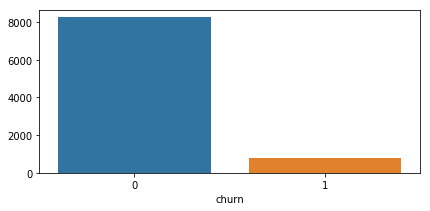

In [37]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
sns.barplot(x=df[target_], y=df.index, estimator=len)
plt.show()

<font color=red size=5> Categorical Variable Data Imbalance</fond>

['og_others_7', 'og_others_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']


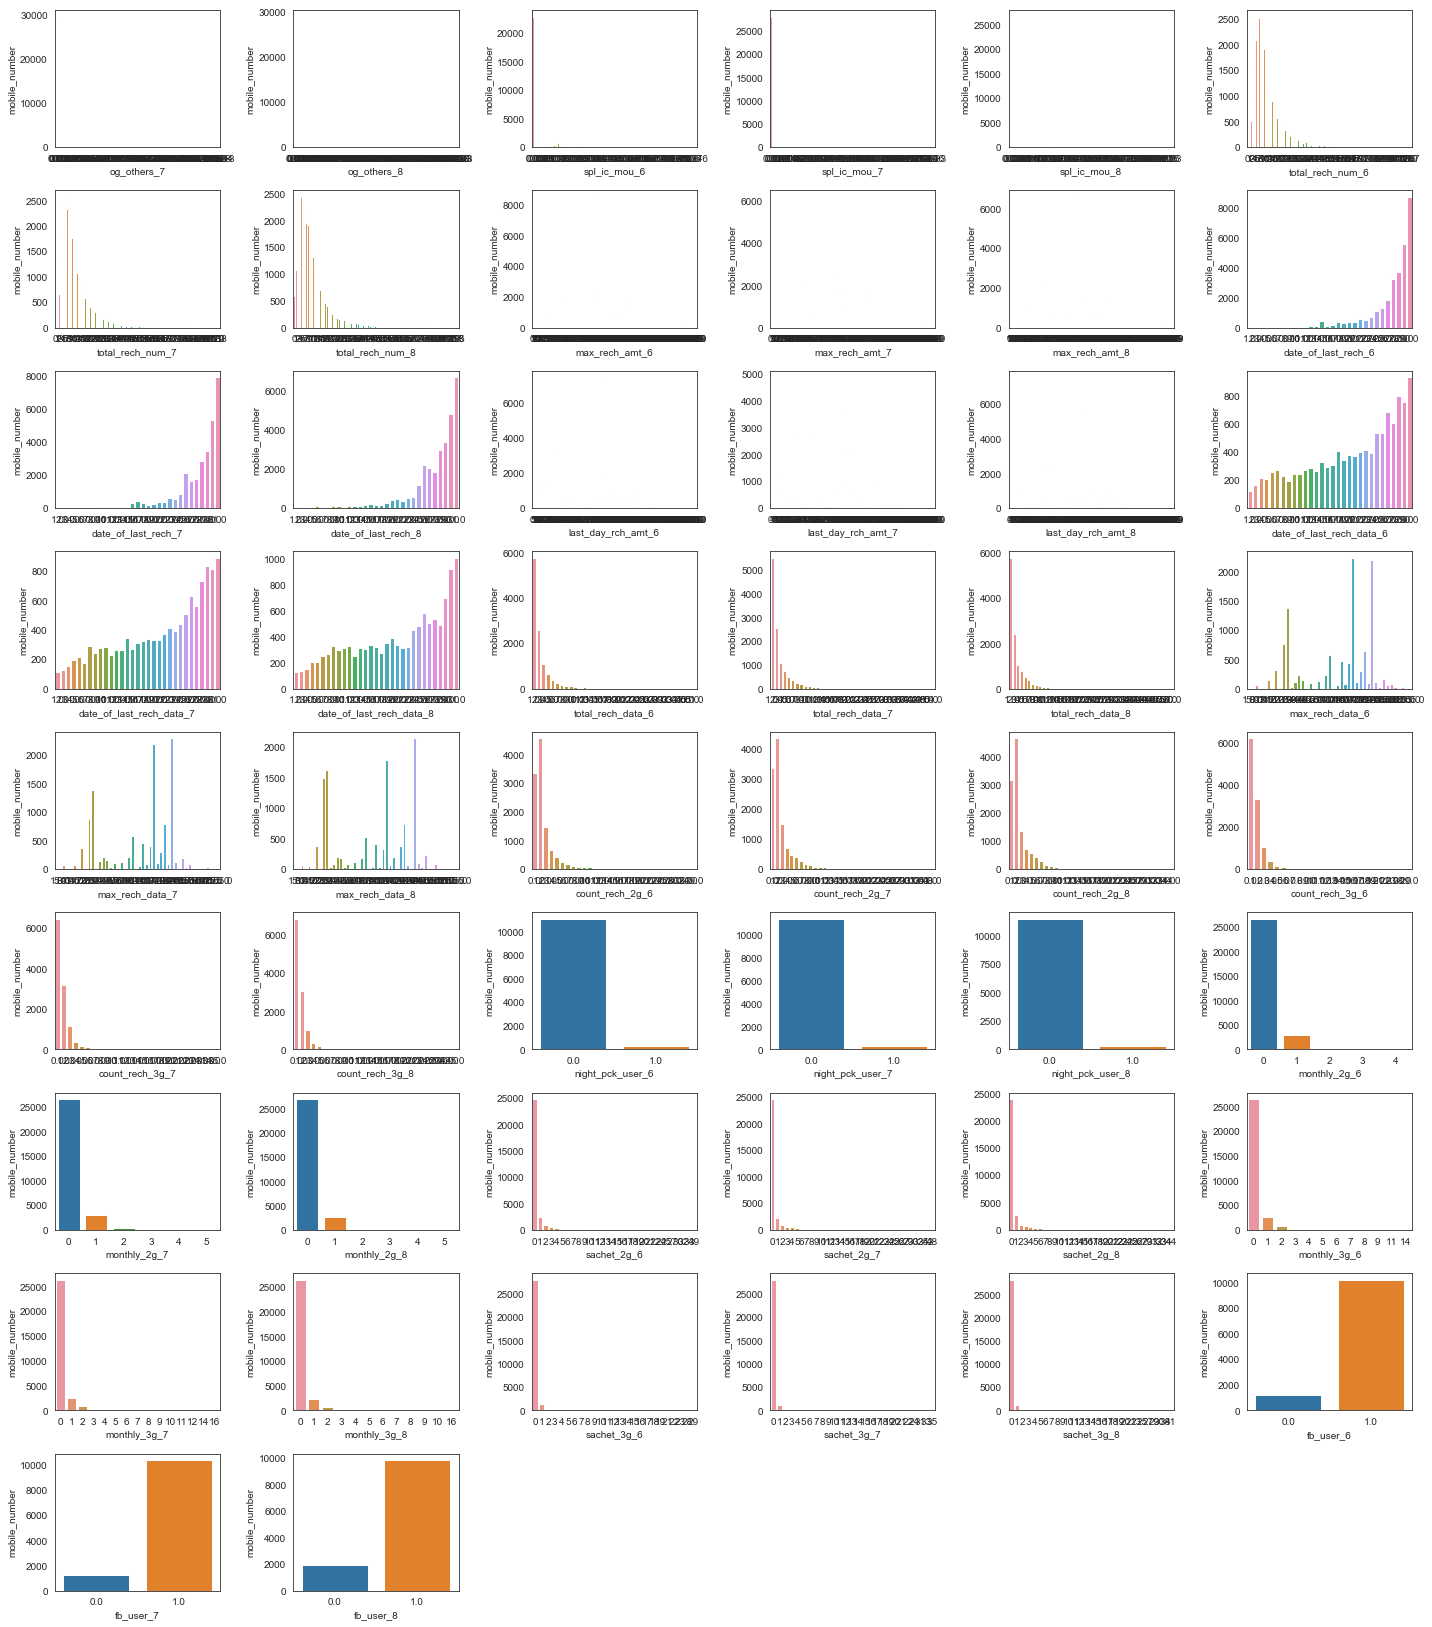

In [38]:
cols_all_cat = get_fld_list(df,"cat",False)
print (cols_all_cat)
sns.set_style("white")
plt.figure(figsize=(20,100))
i=1
while i<=len(cols_all_cat):
    plt.subplot(40,6,i)
    sns.barplot(y=id_, x=cols_all_cat[i-1], data=df, ci=0, estimator=len)
    i+=1
plt.tight_layout()

<font color=red size=5> Numerical Variable Data Distribution</font>

['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_m

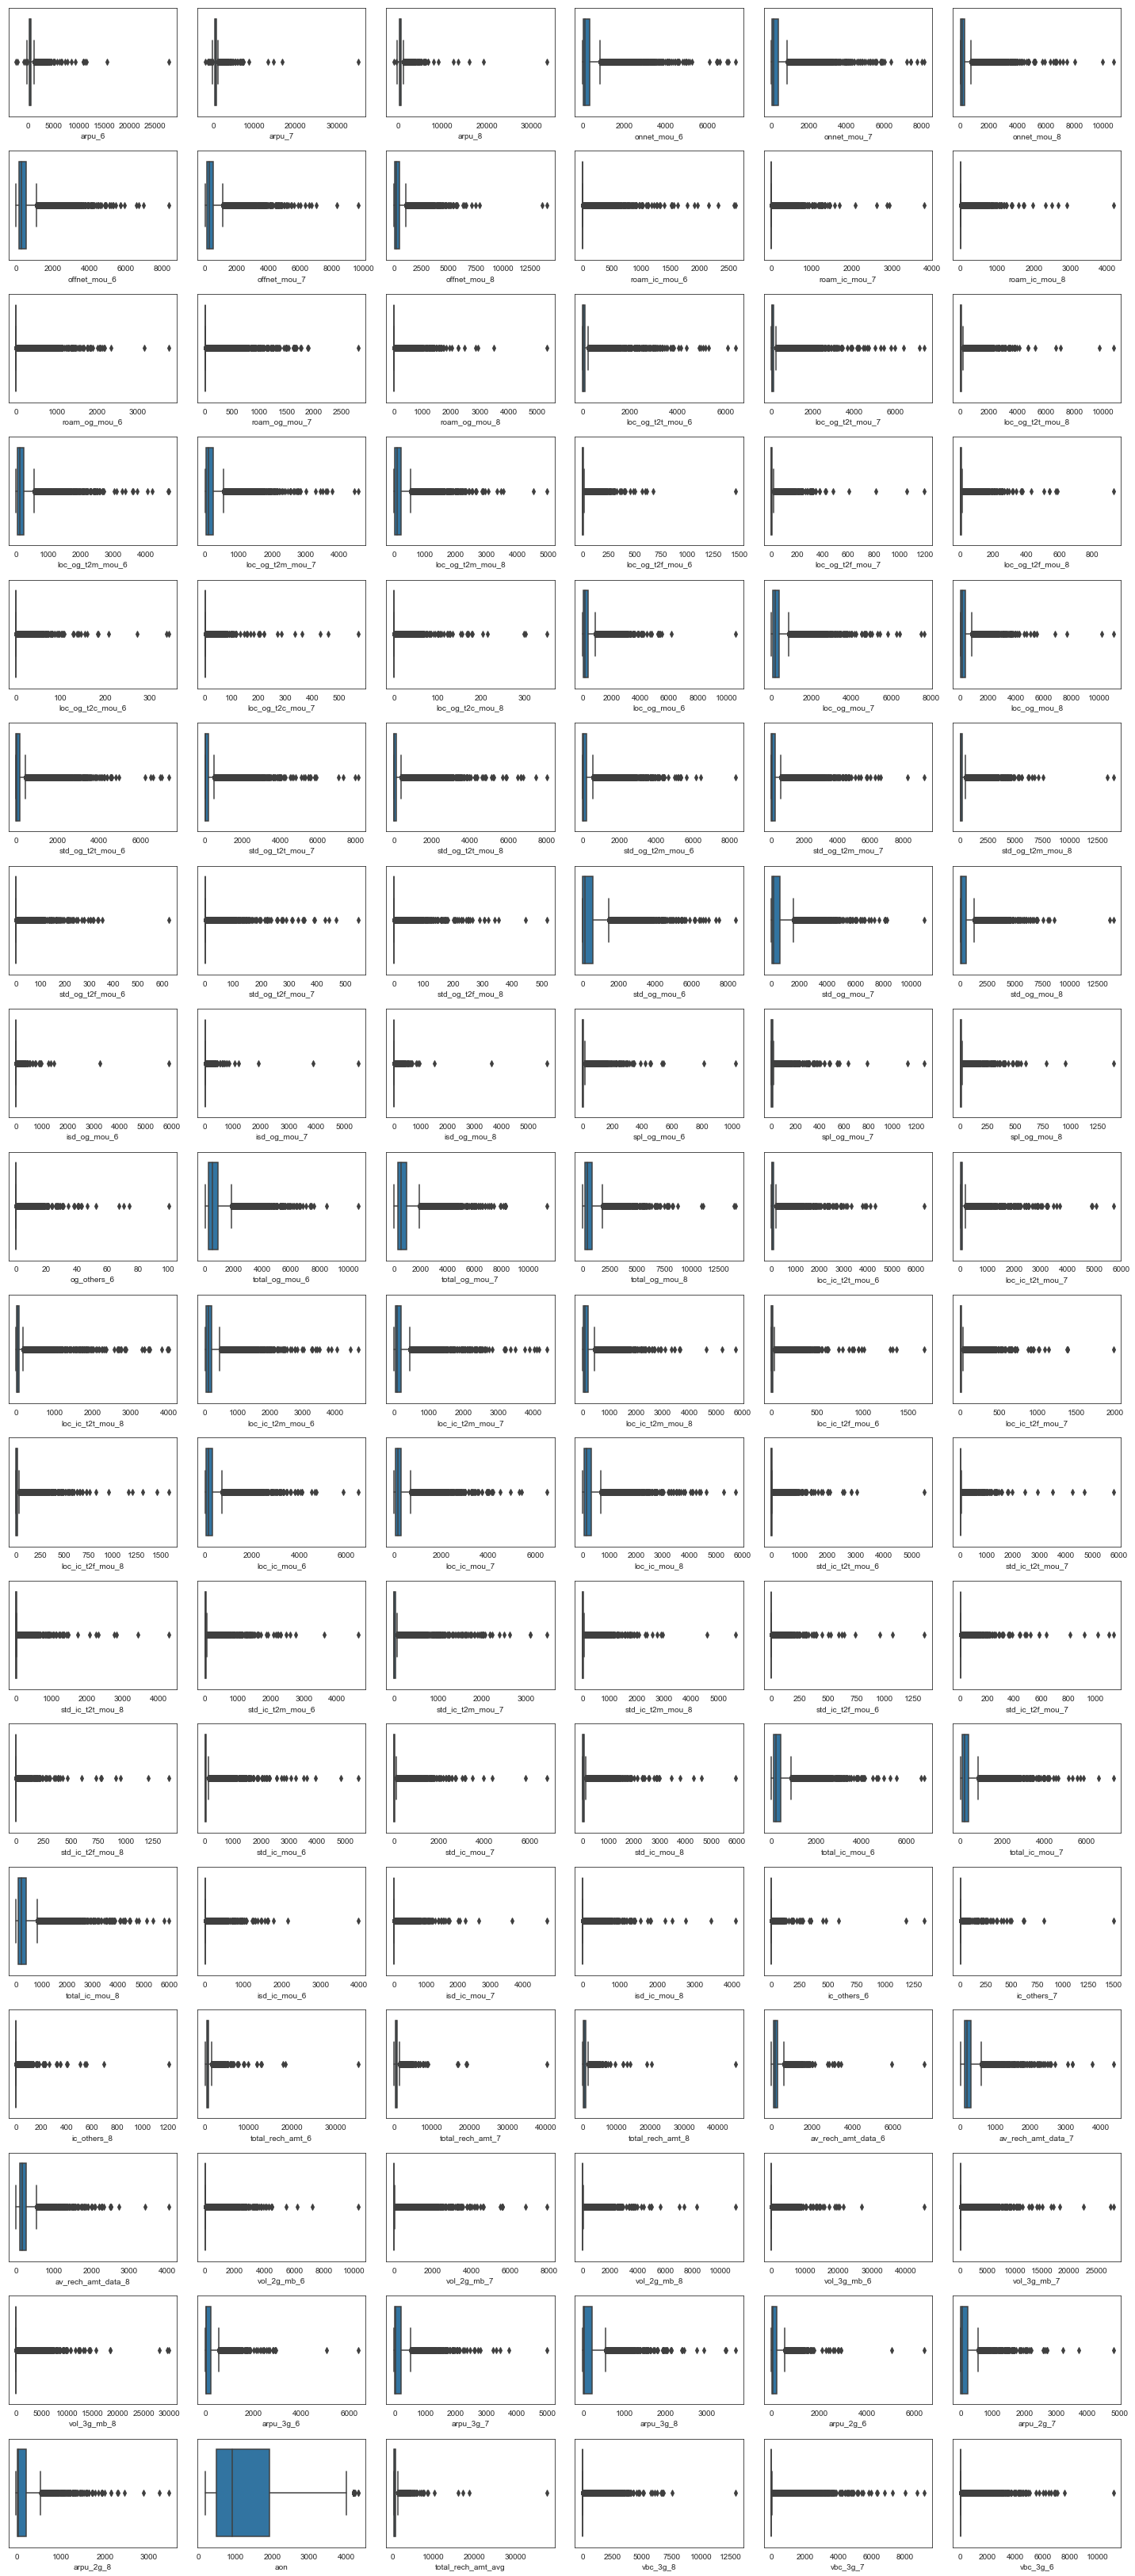

In [39]:
cols_all_num = get_fld_list(df,"num",False)
print (cols_all_num)
sns.set_style("white")
plt.figure(figsize=(20,100))
i=1
while i<=len(cols_all_num):
    plt.subplot(40,6,i)
    sns.boxplot( x=df[ cols_all_num[i-1] ])
    i+=1
plt.tight_layout()
plt.show()

<font color=red size=3> Feature Engigneering</font>

<font color=red size=3> Check Distribution Now</font>

print (cols_all_num)
sns.set_style("white")
plt.figure(figsize=(20,100))
i=1
while i<=len(cols_all_num):
    plt.subplot(40,6,i)
    sns.boxplot( x=df[ cols_all_num[i-1] ])
    i+=1
plt.tight_layout()
plt.show()

<font color=red size=6>Imputing Null Values</font>

<font color=red size=3>__Convert categorical variables into number__</font>

We need to convert values in categorical variables in number for following reasons.
1. So that we can check relation between categorical variable and sales price. 
- So that we can do Categorical Field's null value imputation using K Neighbour Mean. 
- So that we can do the modeling 

<font color=red size=3>__Impute Numeric Value Fields__</font>

In [40]:
cols_all_num =get_fld_list(df,"num",False)
df[cols_all_num].head(5)

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,aon,total_rech_amt_avg,vbc_3g_8,vbc_3g_7,vbc_3g_6
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,NaN,NaN,NaN,NaN,NaN,802,1185.0,57.74,19.38,18.74
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,...,0.0,19.83,NaN,0.0,0.0,315,519.0,21.03,910.65,122.16
13,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,...,NaN,0.00,NaN,NaN,0.2,2607,380.0,0.00,0.00,0.00
16,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,...,NaN,NaN,NaN,NaN,NaN,511,459.0,0.00,2.45,21.89
17,690.008,18.980,25.499,1185.91,9.28,7.79,61.64,0.00,5.54,0.00,...,NaN,NaN,NaN,NaN,NaN,667,408.0,0.00,0.00,0.00


In [41]:
#Impute Numeric Null Values Columns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer()
df_filled = imputer.fit_transform( df )
df_filled = pd.DataFrame(df_filled, columns=df.columns, index= df.index)

#in above steps categorical fields also got imputed. Because Iterative Imputer uses Linear Regression for imputation
#I don't want decimal number in imputed filed so reverting back those imputation.
df[cols_all_num] = df_filled[cols_all_num]

In [42]:
df[cols_all_num].head(5)

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,aon,total_rech_amt_avg,vbc_3g_8,vbc_3g_7,vbc_3g_6
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,89.416446,501.890567,75.576789,54.390010,166.184092,802.0,1185.0,57.74,19.38,18.74
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,...,0.000000,19.830000,92.410961,0.000000,0.000000,315.0,519.0,21.03,910.65,122.16
13,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,...,60.923849,0.000000,96.293170,107.736328,0.200000,2607.0,380.0,0.00,0.00,0.00
16,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,...,66.013492,61.163968,102.592698,91.315787,92.171816,511.0,459.0,0.00,2.45,21.89
17,690.008,18.980,25.499,1185.91,9.28,7.79,61.64,0.00,5.54,0.00,...,40.037026,55.765261,106.241078,96.652450,103.893697,667.0,408.0,0.00,0.00,0.00


In [43]:
#df[cols_all_cat].isna().sum()

<font color=red size=3>__Impute Categorical Value Fields__</font>

In [44]:
cols_all_cat =get_fld_list(df,"cat",False)
df[cols_all_cat].head()

,og_others_7,og_others_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,...,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8
7,0.0,0.0,0.21,0.0,0.0,5,5,7,1580,790,...,0,0,0,0,0,0,0,NaN,NaN,NaN
8,0.0,0.0,0.00,0.0,0.0,19,21,14,90,154,...,3,0,0,0,0,0,0,NaN,1.0,1.0
13,0.0,0.0,0.45,0.0,0.0,6,4,11,110,110,...,3,0,0,0,0,0,0,NaN,NaN,1.0
16,0.0,0.0,0.00,0.0,0.0,10,6,2,110,110,...,0,0,0,0,0,0,0,NaN,NaN,NaN
17,0.0,0.0,0.00,0.0,0.0,19,2,4,110,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN


In [45]:
#Impute Null Categorical Values
#Imputation will be done using non_null cols
def imputeNull_CatValues(df,fld):
 
    X_test = df[NonNullVal_cols]

    cols=NonNullVal_cols.copy()
    if fld not in cols:
        cols.append(fld)


    #training using none-null columns
    df_train = df [cols] [ df[fld].notna()] 

    #supplied fld in dataframe need to be classified. So we need to train using this field
    y_train= df_train[fld]
    X_train = df_train.drop(columns=fld)
    clusters = len(y_train.unique() )

    from sklearn.neighbors import KNeighborsClassifier
    km = KNeighborsClassifier(n_neighbors=clusters)

    #t= X_train.isna().sum(axis=0)>=0
    #print ( X_train.loc[ ::,t ])
    #print (y_train.isna().sum())

    km.fit(X_train,y_train.astype(int))
    pred_train_clusterid = km.predict(X_train)
    pred_test_clusterid = km.predict(X_test)

    print (fld,"Accuracy on Train Dataset :",
    round(metrics.accuracy_score(y_train.astype(int), pred_train_clusterid),2))
    print ("==========================================")

    df1 = pd.DataFrame( {"prediction":pred_test_clusterid, "actual":df[fld]})

    #create a need field in temp dataframe df1, 
    #for a given field if actual==0 (it has null value) then use prediction to replace
    df1.loc[ df1["actual"].isna(),fld] = df1["prediction"]

    #If actual is not null then we should not use predicted cluster value, so use actual value
    df1.loc[ ~df1["actual"].isna(),fld] = df1["actual"]

    return (df1[fld])

In [46]:
## This steps impute null values only in Categorical Fields
#get list of non-null-value fields. These fields will be used for creating cluster and imputation using KNeighborsClassifier
temp =df.isna().sum()
NonNullVal_cols = list(temp[ temp==0].index)

for colname in cols_all_cat: #Get catgorical variable
    if colname not in NonNullVal_cols: #Dont impute if the cat variable in Non-Null columns
        print (colname)
        df[colname] = imputeNull_CatValues(df,colname)

og_others_7
og_others_7 Accuracy on Train Dataset : 1.0
og_others_8
og_others_8 Accuracy on Train Dataset : 1.0
spl_ic_mou_6
spl_ic_mou_6 Accuracy on Train Dataset : 1.0
spl_ic_mou_7
spl_ic_mou_7 Accuracy on Train Dataset : 1.0
spl_ic_mou_8
spl_ic_mou_8 Accuracy on Train Dataset : 1.0
date_of_last_rech_6
date_of_last_rech_6 Accuracy on Train Dataset : 0.31
date_of_last_rech_7
date_of_last_rech_7 Accuracy on Train Dataset : 0.29
date_of_last_rech_8
date_of_last_rech_8 Accuracy on Train Dataset : 0.26
date_of_last_rech_data_6
date_of_last_rech_data_6 Accuracy on Train Dataset : 0.14
date_of_last_rech_data_7
date_of_last_rech_data_7 Accuracy on Train Dataset : 0.14
date_of_last_rech_data_8
date_of_last_rech_data_8 Accuracy on Train Dataset : 0.14
total_rech_data_6
total_rech_data_6 Accuracy on Train Dataset : 0.51
total_rech_data_7
total_rech_data_7 Accuracy on Train Dataset : 0.48
total_rech_data_8
total_rech_data_8 Accuracy on Train Dataset : 0.49
max_rech_data_6
max_rech_data_6 Accurac

In [47]:
#Check any null value column
df.iloc[:, list(df.isna().sum()>0)].head(2)

""
7
8


In [48]:
#Check Null Values
(df.isnull().sum()/len(df)*100).sort_values()[::-1]

vbc_3g_6                    0.0
vbc_3g_7                    0.0
loc_ic_t2t_mou_8            0.0
loc_ic_t2t_mou_7            0.0
loc_ic_t2t_mou_6            0.0
total_og_mou_8              0.0
total_og_mou_7              0.0
total_og_mou_6              0.0
og_others_8                 0.0
og_others_7                 0.0
og_others_6                 0.0
spl_og_mou_8                0.0
spl_og_mou_7                0.0
spl_og_mou_6                0.0
isd_og_mou_8                0.0
isd_og_mou_7                0.0
isd_og_mou_6                0.0
std_og_mou_8                0.0
std_og_mou_7                0.0
loc_ic_t2m_mou_6            0.0
loc_ic_t2m_mou_7            0.0
loc_ic_t2m_mou_8            0.0
std_ic_t2m_mou_6            0.0
std_ic_mou_7                0.0
std_ic_mou_6                0.0
std_ic_t2f_mou_8            0.0
std_ic_t2f_mou_7            0.0
std_ic_t2f_mou_6            0.0
std_ic_t2m_mou_8            0.0
std_ic_t2m_mou_7            0.0
                           ... 
ic_other

<font color=red size=4>For Regression Problem, Visualising Relationship between y & X</font>

<font color=red size=5>Check y & Cateorical Variable Relationship</font>

<font color=red size=5> Check y & Numeric Variable Relationship</font>

<font color=red size=5> Check Degree of Correlation between y & Numeric Variable</font>

<font color=red size=5> Create Dummy Fields</font>

In [49]:
df.shape

(30011, 160)

<font color=red size=5> Find & Remove Outliers</font>

<font color=red size=3> Identify Outliers</font>

In [50]:
df1= df.copy()

In [51]:
df[cols_all_num].head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,aon,total_rech_amt_avg,vbc_3g_8,vbc_3g_7,vbc_3g_6
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,89.416446,501.890567,75.576789,54.390010,166.184092,802.0,1185.0,57.74,19.38,18.74
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,...,0.000000,19.830000,92.410961,0.000000,0.000000,315.0,519.0,21.03,910.65,122.16
13,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,...,60.923849,0.000000,96.293170,107.736328,0.200000,2607.0,380.0,0.00,0.00,0.00
16,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,...,66.013492,61.163968,102.592698,91.315787,92.171816,511.0,459.0,0.00,2.45,21.89
17,690.008,18.980,25.499,1185.91,9.28,7.79,61.64,0.00,5.54,0.00,...,40.037026,55.765261,106.241078,96.652450,103.893697,667.0,408.0,0.00,0.00,0.00


In [52]:
#df.loc[:,df.isna().sum()>0]

In [53]:
#df.loc[:,list(df.isna().sum()>0)]

In [54]:
#outlier_det.sort_values("Dif", ascending=False).to_csv("outlier.csv")

<font color=red size=3> Visualize Outliers Distribution</font>

<font color=red size=3> Remove Outliers</font>

In [55]:
#dict( df[outlier_cols].quantile(.95, axis = 0))

In [56]:
#df=df1.copy()

In [57]:
#outlier_cols_dict = dict( df[outlier_cols].quantile(.99, axis = 0))

#for k,v in outlier_cols_dict.items():
#    df =  df[ df[k]<=v]

<font color=red size=3> Visualize Again : Distribution of Old Outlier Fields</font>

In [58]:
#df.shape

In [59]:
#df.churn.astype("category").value_counts()

<font color=blue size=4>__Store Cleaned Data and Dummy Parameter Mapped in separate File__</font>

In [60]:
#df.to_csv("clean_train_data_prudential.csv")
#all_fldmap.to_csv("all_fldmap_prudential.csv")

<font color=red size=5>__Split Dataset & Scale Numeric Fields__</font>

In [61]:
#Split Dataset in X & y
Xcols = list(df.columns)
Xcols.remove(target_)

X = df[Xcols]
y = df[target_]

In [62]:
# split X, y into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)
X_train_id = X_train[id_]
X_test_id = X_test[id_]

X_train = X_train.drop(columns=id_)
X_test = X_test.drop(columns=id_)

In [63]:
X_train.head(2)

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,total_rech_amt_avg,vbc_3g_8,vbc_3g_7,vbc_3g_6
4715,331.304,480.315,386.671,336.33,564.78,424.11,154.94,71.08,88.14,0.0,...,0,0,1.0,1.0,0.0,353.0,461.5,0.00,0.00,0.00
15222,320.013,508.681,480.398,110.08,27.54,131.03,220.86,117.84,168.99,0.0,...,0,0,1.0,1.0,1.0,1076.0,464.0,170.16,67.21,48.78


In [64]:
# scaling the numeric feature features in train and test
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train= pd.DataFrame(sc.fit_transform(X_train[cols_all_num]), columns=cols_all_num, index=X_train.index)
X_test= pd.DataFrame(sc.transform(X_test[cols_all_num]), columns=cols_all_num, index=X_test.index)

In [65]:
X_train.head(2)

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,aon,total_rech_amt_avg,vbc_3g_8,vbc_3g_7,vbc_3g_6
4715,-0.618756,-0.252174,-0.318969,0.078632,0.522991,0.303439,-0.569002,-0.729615,-0.625963,-0.238263,...,-0.593549,-0.115844,-0.138633,-0.781454,-0.039624,-0.938635,-0.520352,-0.329669,-0.330304,-0.310692
15222,-0.646107,-0.187018,-0.120157,-0.412727,-0.578274,-0.309775,-0.428518,-0.634190,-0.456984,-0.238263,...,0.280608,-0.649756,-0.274319,-0.496344,-0.791985,-0.198224,-0.514834,0.104407,-0.168340,-0.185233


In [66]:
print(y_train.mean())
print(y_test.mean())

0.08678059694387585
0.08551754775655264


### PCA Compression

In [67]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver="randomized",random_state=100)
pca_scaled = pca.fit_transform(X,y)
pca_scaled = pd.DataFrame(pca_scaled, index=X.index)
pca_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,149,150,151,152,153,154,155,156,157,158
7,5.213224e+05,752.238723,1263.060572,2031.879351,704.219390,994.664004,2432.110500,557.204118,-119.789133,854.364293,...,-0.002126,-0.002223,0.000237,-0.000347,0.001854,-0.000649,0.001437,-0.005589,0.000898,-1.959180e-11
8,-3.019219e+05,-974.009721,-330.214376,-980.674350,73.674626,835.716978,115.702430,-300.267771,464.470898,-444.199742,...,0.001663,0.001594,0.001912,0.003859,0.000858,-0.000845,-0.002045,0.000564,0.000927,-2.302591e-10
13,-9.687899e+05,-36.356342,-666.085366,295.430789,-569.286417,-726.652007,-234.031457,239.442290,-586.377289,1088.138673,...,-0.001921,0.001163,0.006787,0.000533,-0.002262,0.002751,-0.002230,-0.000795,-0.000093,6.164936e-11
16,3.473588e+05,-1206.225330,-726.512787,-56.011254,291.850329,576.512865,17.363690,-348.813422,-12.215165,16.791828,...,0.003413,0.000449,-0.004219,0.000803,0.001076,0.000856,0.002061,-0.001985,0.004630,2.528287e-10
17,1.035477e+06,-933.278526,-1050.708052,-811.603625,-486.261417,833.126294,-789.705235,1081.966657,82.987987,683.077773,...,0.000428,-0.001510,0.001197,-0.000270,0.000057,-0.002140,0.001547,0.000191,-0.000038,8.644715e-11


In [68]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#Only 1 PCA feature can explain 99.99% of variance

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 10

In [69]:
df_pca = pd.DataFrame({"mobile_number": df[id_], "PCA1":list(pca_scaled[0]),
                       "PCA2":list(pca_scaled[1]),"churn": df[target_]})
df_pca.head(10)

,mobile_number,PCA1,PCA2,churn
7,7000701601,5.213224e+05,752.238723,1
8,7001524846,-3.019219e+05,-974.009721,0
13,7002191713,-9.687899e+05,-36.356342,0
16,7000875565,3.473588e+05,-1206.225330,0
17,7000187447,1.035477e+06,-933.278526,0
21,7002124215,-9.012909e+05,1244.660812,0
24,7001125315,9.760775e+04,-858.168591,0
33,7000149764,1.073159e+06,-2313.738387,0
38,7000815202,4.077217e+05,-102.676018,0
41,7000721289,5.016341e+05,-1232.410834,0


In [70]:
# split X, y into train and test
X_pca = df_pca[ ['PCA1','PCA2']]
y_pca = df_pca[target_]

from sklearn.model_selection import train_test_split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

### PCA Feature Engineering

In [71]:
#After Removing Outlier

<font color=red size=5>__Start Modeling__</font>

<font color=red size=5>Common Function Used in Modeling</font>

In [72]:
def predict_with_prob(model,y_, X_):
    y_pred = model.predict_proba(X_)
    df_pred = pd.DataFrame({"act_churn": y_, "churn_prob":list(y_pred[:,1]) })

    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        df_pred[i]= df_pred.churn_prob.map(lambda x: 1 if x > i else 0)
    return df_pred

In [73]:
def create_metrics_table(df_pred):
    df_cutoff = pd.DataFrame( columns = ['prob','accuracy','recall','specificity','precision'])
    from sklearn.metrics import confusion_matrix

    # TP = confusion[1,1] # true positive 
    # TN = confusion[0,0] # true negatives
    # FP = confusion[0,1] # false positives
    # FN = confusion[1,0] # false negatives

    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(df_pred.act_churn, df_pred[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1

        specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        recall = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        precision = cm1[1,1]/(cm1[0,1]+cm1[1,1])
        df_cutoff.loc[i] =[ i ,accuracy,recall,specificity,precision]
    return df_cutoff

In [74]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
def plot_roc(df_cutoff):
    plt.figure(figsize=(15,3))
    sns.lineplot(x="prob", y='accuracy', data=df_cutoff, color="red")
    sns.lineplot(x="prob", y='recall'  , data=df_cutoff, color="green")
    sns.lineplot(x="prob", y='specificity'   , data=df_cutoff, color="blue")
    sns.lineplot(x="prob", y='precision'   , data=df_cutoff, color="black")
    
    plt.legend(["Accuracy","Recall","specificity","precision"])
    plt.show()

In [75]:
def predict_score(model, y_act, X_, probability):
    
    y_pred = model.predict_proba(X_)
    df_pred = pd.DataFrame({"y_actual": y_act, "pred_prob":list(y_pred[:,1]) })
    df_pred["y_pred"] = df_pred["pred_prob"].apply(lambda x: 1 if x>probability else 0)
    
    cm1 = metrics.confusion_matrix(y_act, df_pred.y_pred )
    total1=sum(sum(cm1))

    accuracy = (cm1[0,0]+cm1[1,1])/total1
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    recall = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    precision = cm1[1,1]/(cm1[0,1]+cm1[1,1])
        
    print ("Accuracy:\t", accuracy )
    print ("Recall:  \t", recall )
    print ("Specificity:\t", specificity )
    print ("Precision:\t", precision )
    
    print ("Confusion Matrix:\n", metrics.confusion_matrix(y_act, df_pred.y_pred) )

In [76]:
# plotting model parameters against the metrics
def plot_gridSearch_para(df_grid, parameters, matrix):
    plt.figure(figsize=(15,15))
    i=1
    for parameter in parameters:
        plt.subplot(6,3,i)
        i+=1

        sns.lineplot(x=df_grid[parameter], 
                     y=df_grid["mean_train_score"], 
                     label="training accuracy")

        sns.lineplot(x= df_grid[parameter], 
                 y= df_grid["mean_test_score"], 
                 label="test accuracy")

        #plt.xlabel("max_features")
        plt.ylabel(matrix)
        plt.legend()
    plt.show()

<font color=red size=6>__Logistic Regression__</font>

<font color=red size=3>__Logistic Regression Using PCA Features__</font>

In [77]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(class_weight="balanced")
model_lr.fit(X_train_pca,y_train_pca)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.086781  1.000000     0.000000   0.086781
0.1   0.1  0.086781  1.000000     0.000000   0.086781
0.2   0.2  0.086781  1.000000     0.000000   0.086781
0.3   0.3  0.086781  1.000000     0.000000   0.086781
0.4   0.4  0.086781  1.000000     0.000000   0.086781
0.5   0.5  0.515162  0.552386     0.511624   0.097051
0.6   0.6  0.913219  0.000000     1.000000        NaN
0.7   0.7  0.913219  0.000000     1.000000        NaN
0.8   0.8  0.913219  0.000000     1.000000        NaN
0.9   0.9  0.913219  0.000000     1.000000        NaN


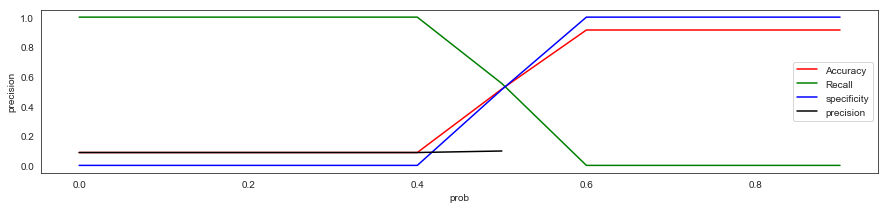

In [78]:
#Visualize the result on train data
df_pred=predict_with_prob(model_lr,y_train_pca,X_train_pca)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.085518  1.000000     0.000000   0.085518
0.1   0.1  0.085518  1.000000     0.000000   0.085518
0.2   0.2  0.085518  1.000000     0.000000   0.085518
0.3   0.3  0.085518  1.000000     0.000000   0.085518
0.4   0.4  0.085518  1.000000     0.000000   0.085518
0.5   0.5  0.511106  0.576623     0.504979   0.098230
0.6   0.6  0.914482  0.000000     1.000000        NaN
0.7   0.7  0.914482  0.000000     1.000000        NaN
0.8   0.8  0.914482  0.000000     1.000000        NaN
0.9   0.9  0.914482  0.000000     1.000000        NaN


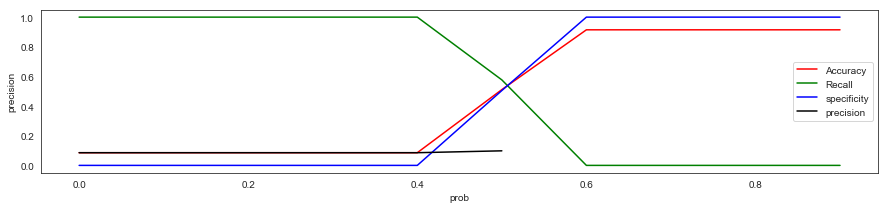

In [79]:
#Visualize the result on test data
df_pred=predict_with_prob(model_lr,y_test_pca,X_test_pca)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [80]:
#Use optimum cutoff and see result on train data
predict_score(model_lr, y_train_pca, X_train_pca, .50)

Accuracy:	 0.5151616127957348
Recall:  	 0.5523861766319254
Specificity:	 0.5116242702251876
Precision:	 0.0970508866615266
Confusion Matrix:
 [[9815 9369]
 [ 816 1007]]


In [81]:
#Use optimum cutoff and see result on test data
predict_score(model_lr, y_test_pca, X_test_pca, .50)

Accuracy:	 0.5111061750333186
Recall:  	 0.5766233766233766
Specificity:	 0.5049793538984697
Precision:	 0.09823008849557523
Confusion Matrix:
 [[4158 4076]
 [ 326  444]]


<font color=red size=3>__Logistic Regression Using Normal Features__</font>

In [82]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(class_weight="balanced")
model_lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.086781  1.000000     0.000000   0.086781
0.1   0.1  0.371257  0.975315     0.313855   0.119001
0.2   0.2  0.536726  0.948985     0.497550   0.152168
0.3   0.3  0.659590  0.918815     0.634956   0.193017
0.4   0.4  0.762936  0.877674     0.752033   0.251691
0.5   0.5  0.839911  0.826659     0.841170   0.330918
0.6   0.6  0.887133  0.757543     0.899447   0.417221
0.7   0.7  0.910458  0.645639     0.935623   0.487977
0.8   0.8  0.922883  0.486561     0.964345   0.564609
0.9   0.9  0.927643  0.358201     0.981756   0.651047


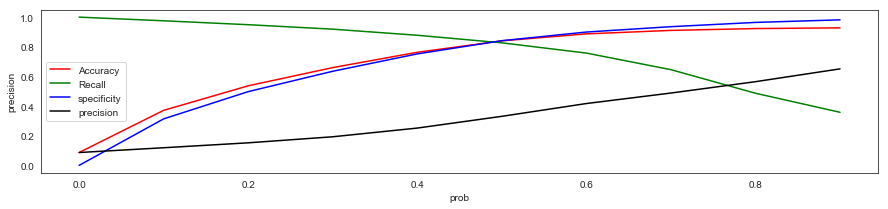

In [83]:
#Visualize the result on train data
df_pred=predict_with_prob(model_lr,y_train,X_train)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.085518  1.000000     0.000000   0.085518
0.1   0.1  0.362728  0.976623     0.305319   0.116193
0.2   0.2  0.524989  0.950649     0.485183   0.147254
0.3   0.3  0.657152  0.919481     0.632621   0.189660
0.4   0.4  0.764549  0.881818     0.753583   0.250739
0.5   0.5  0.842403  0.844156     0.842239   0.333504
0.6   0.6  0.891937  0.764935     0.903813   0.426503
0.7   0.7  0.916926  0.671429     0.939883   0.510870
0.8   0.8  0.930809  0.519481     0.969274   0.612557
0.9   0.9  0.932586  0.370130     0.985183   0.700246


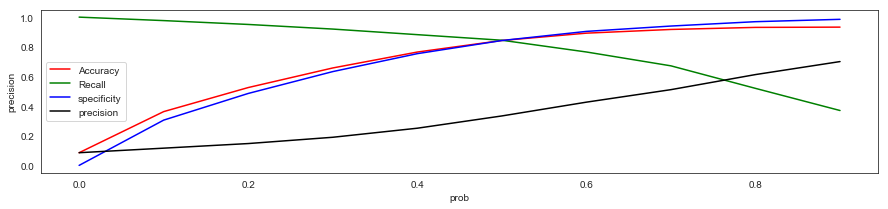

In [84]:
#Visualize the result on test data
df_pred=predict_with_prob(model_lr,y_test,X_test)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [85]:
#Use optimum cutoff and see result on train data
predict_score(model_lr, y_train, X_train, .50)

Accuracy:	 0.8399105060218023
Recall:  	 0.8266593527153044
Specificity:	 0.8411697247706422
Precision:	 0.3309178743961353
Confusion Matrix:
 [[16137  3047]
 [  316  1507]]


In [87]:
#Use optimum cutoff and see result on test data
predict_score(model_lr, y_test, X_test, .50)

Accuracy:	 0.8424033762772102
Recall:  	 0.8441558441558441
Specificity:	 0.8422394947777508
Precision:	 0.3335043612108774
Confusion Matrix:
 [[6935 1299]
 [ 120  650]]


<font color=red size=5>__Modeling Using PCA__</font>

<font color=red size=6>__RandomForest Classifier__</font>

<font color=red size=5>__RandomForestClassfier Using PCA Features__</font>

In [88]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {"max_depth" : [2, 5],
              "n_estimators": [100, 200, 400],
              "max_features": [2],
              "min_samples_leaf": [50],
              "min_samples_split":[50]
              }

model_rfc_pca = RandomForestClassifier(random_state=100, class_weight="balanced")

folds = 3
grid_search_rfc_pca = GridSearchCV(model_rfc_pca, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

grid_search_rfc_pca.fit(X_train_pca,  y_train_pca)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=100,
                                              verbose=0, warm_start=False),
           

In [89]:
df_scores = pd.DataFrame( grid_search_rfc_pca.cv_results_)
df_scores.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.954252,0.051726,0.066520,0.019639,2,2,50,50,100,"{'max_depth': 2, 'max_features': 2, 'min_sampl...",...,0.560379,0.582514,0.568445,0.009982,3,0.596149,0.593256,0.588413,0.592606,0.003191
1,2.183567,0.345266,0.172272,0.010419,2,2,50,50,200,"{'max_depth': 2, 'max_features': 2, 'min_sampl...",...,0.561062,0.581919,0.569145,0.009137,2,0.596810,0.592275,0.587262,0.592116,0.003900
2,4.785924,0.130277,0.355432,0.009348,2,2,50,50,400,"{'max_depth': 2, 'max_features': 2, 'min_sampl...",...,0.562772,0.583358,0.569947,0.009490,1,0.597017,0.592581,0.588685,0.592761,0.003404
3,2.314973,0.126111,0.113120,0.016554,5,2,50,50,100,"{'max_depth': 5, 'max_features': 2, 'min_sampl...",...,0.558840,0.579158,0.566668,0.008925,5,0.643462,0.653679,0.639982,0.645707,0.005813
4,4.775995,0.041843,0.228738,0.005050,5,2,50,50,200,"{'max_depth': 5, 'max_features': 2, 'min_sampl...",...,0.557802,0.577243,0.566121,0.008180,6,0.644001,0.653323,0.640601,0.645975,0.005378


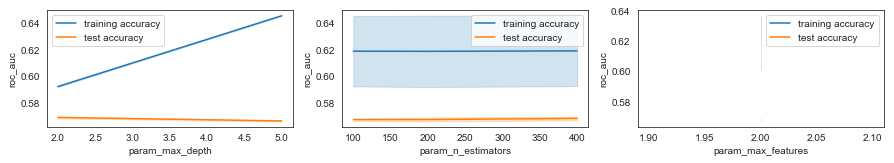

In [91]:
#para_list=["param_max_depth","param_n_estimators","param_max_features","param_min_samples_leaf","param_min_sample_split"]
para_list=["param_max_depth","param_n_estimators","param_max_features"]
plot_gridSearch_para(df_scores, para_list, "roc_auc")

<font color=red size=3>__Optimising RandomForestClassier PCA Model Parameters__</font>

In [94]:
from sklearn.ensemble import RandomForestClassifier

model_rfc_pca1 = RandomForestClassifier(max_depth=5,
                                        n_estimators=100,
                                        max_features=2,
                                        min_samples_leaf=50,
                                        min_samples_split=50,
                                        random_state=100, class_weight="balanced")

model_rfc_pca1.fit(X_train_pca, y_train_pca)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features=2,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=50,
                       min_samples_split=50, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=100, verbose=0, warm_start=False)

<font color=red size=3>__Evaluating RandomForestClassifer PCA Model__</font>

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.086781  1.000000     0.000000   0.086781
0.1   0.1  0.086781  1.000000     0.000000   0.086781
0.2   0.2  0.091684  0.999451     0.005421   0.087169
0.3   0.3  0.123435  0.992869     0.040815   0.089555
0.4   0.4  0.159375  0.974767     0.081891   0.091645
0.5   0.5  0.679821  0.465716     0.700167   0.128617
0.6   0.6  0.863284  0.161821     0.929942   0.179988
0.7   0.7  0.910649  0.011519     0.996090   0.218750
0.8   0.8  0.913219  0.000000     1.000000        NaN
0.9   0.9  0.913219  0.000000     1.000000        NaN


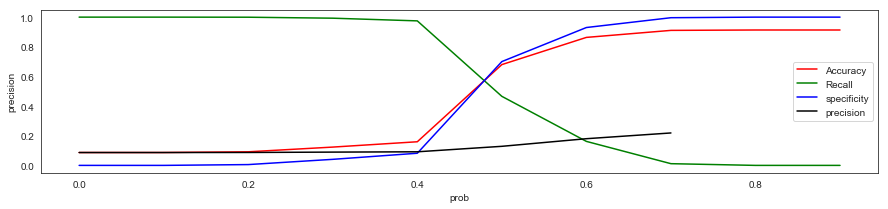

In [95]:
#Evaluate on Train Data
df_pred=predict_with_prob(model_rfc_pca1,y_train_pca,X_train_pca)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [98]:
#Use optimum cutoff and see result on train data
predict_score(model_rfc_pca1, y_train_pca, X_train_pca, .45)

Accuracy:	 0.3623554053410768
Recall:  	 0.8244651673066374
Specificity:	 0.31844245204336946
Precision:	 0.10310056249142543
Confusion Matrix:
 [[ 6109 13075]
 [  320  1503]]


     prob  accuracy    recall  specificity  precision
0.0   0.0  0.085518  1.000000     0.000000   0.085518
0.1   0.1  0.085518  1.000000     0.000000   0.085518
0.2   0.2  0.089183  0.994805     0.004494   0.085462
0.3   0.3  0.123834  0.980519     0.043721   0.087496
0.4   0.4  0.159151  0.964935     0.083799   0.089659
0.5   0.5  0.668703  0.431169     0.690916   0.115398
0.6   0.6  0.854953  0.138961     0.921909   0.142667
0.7   0.7  0.911706  0.015584     0.995506   0.244898
0.8   0.8  0.914482  0.000000     1.000000        NaN
0.9   0.9  0.914482  0.000000     1.000000        NaN


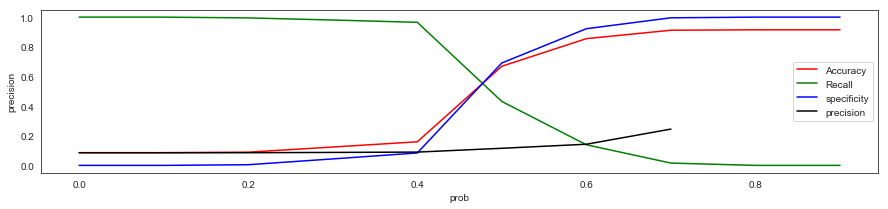

In [99]:
#Evaluate on Test Data
df_pred=predict_with_prob(model_rfc_pca1,y_test_pca,X_test_pca)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [102]:
#Use optimum cutoff and see result on test data
predict_score(model_rfc_pca1, y_test_pca, X_test_pca, .45)

Accuracy:	 0.3538427365615282
Recall:  	 0.8025974025974026
Specificity:	 0.3118775807626913
Precision:	 0.09834500318268619
Confusion Matrix:
 [[2568 5666]
 [ 152  618]]


<font color=red size=5>__RandomForestClassifer using Normal Features__</font>

In [104]:
param_grid = {"max_depth" : range(2, 20, 5),
              "n_estimators": [100, 200, 400],
              "max_features": [10,15,20,25],
              "min_samples_leaf": [25,50,100,150,200],
              "min_samples_split":[25,50,100,150,200]
              }

In [155]:
from sklearn.ensemble import RandomForestClassifier

model_rfc_nor= RandomForestClassifier(class_weight="balanced", random_state=100)

folds = 3
grid_search_rfc_nor = GridSearchCV(model_rfc_nor, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True, 
                               verbose = 1)

grid_search_rfc_nor.fit(X_train,  y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   17.9s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=100,
                                              verbose=0, warm_start=False),
           

<font color=red size=3>__Evaluating RandomForestClassifer Model__</font>

In [156]:
df_scores = pd.DataFrame( grid_search_rfc_nor.cv_results_)
df_scores.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.229496,0.147999,0.022955,0.003163,25,{'min_samples_split': 25},0.896930,0.901952,0.895801,0.898228,0.002674,4,0.993287,0.993467,0.992971,0.993242,0.000205
1,1.516720,0.296551,0.029953,0.004978,50,{'min_samples_split': 50},0.906822,0.903140,0.904174,0.904712,0.001550,3,0.985860,0.985083,0.984334,0.985092,0.000623
2,1.485591,0.046783,0.035821,0.001154,100,{'min_samples_split': 100},0.909088,0.908050,0.907953,0.908363,0.000514,1,0.973864,0.972850,0.974473,0.973729,0.000669
3,1.395194,0.066716,0.030331,0.004000,150,{'min_samples_split': 150},0.911811,0.911970,0.896574,0.906786,0.007220,2,0.963834,0.965625,0.966103,0.965187,0.000976


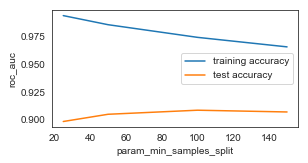

In [158]:
para_list=["param_max_depth","param_n_estimators","param_max_features","param_min_samples_leaf","param_min_samples_split"]

plot_gridSearch_para(df_scores, para_list, "roc_auc")

<font color=red size=3>__Optimising RandomForestClassier Model Parameters__</font>

In [160]:
from sklearn.ensemble import RandomForestClassifier

model_rfc_nor1= RandomForestClassifier(max_depth=7,n_estimators=100,
                                       max_features=10,min_samples_leaf=50, 
                                       min_samples_split=50,class_weight="balanced", random_state=100)

model_rfc_nor1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features=10,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=50,
                       min_samples_split=50, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=100, verbose=0, warm_start=False)

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.086781  1.000000     0.000000   0.086781
0.1   0.1  0.241539  0.999451     0.169516   0.102625
0.2   0.2  0.640168  0.979155     0.607955   0.191812
0.3   0.3  0.812729  0.925946     0.801970   0.307636
0.4   0.4  0.869948  0.874931     0.869475   0.389119
0.5   0.5  0.906365  0.808557     0.915659   0.476714
0.6   0.6  0.927120  0.730115     0.945840   0.561603
0.7   0.7  0.936831  0.640702     0.964971   0.634783
0.8   0.8  0.940591  0.540318     0.978628   0.706093
0.9   0.9  0.940591  0.446517     0.987542   0.773029


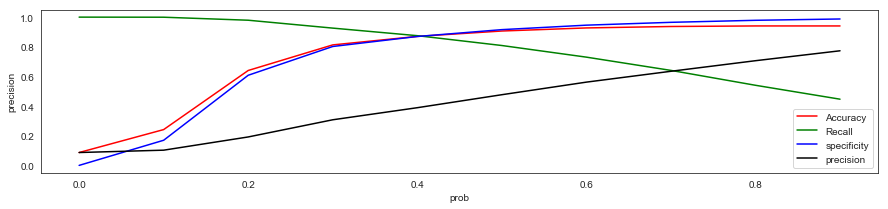

In [161]:
df_pred=predict_with_prob(model_rfc_nor1,y_train,X_train)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [162]:
predict_score(model_rfc_nor1, y_train, X_train, .40)

Accuracy:	 0.8699481125339172
Recall:  	 0.8749314317059792
Specificity:	 0.8694745621351125
Precision:	 0.3891192973896072
Confusion Matrix:
 [[16680  2504]
 [  228  1595]]


In [163]:
predict_score(model_rfc_nor1, y_test, X_test, .40)

Accuracy:	 0.8707241226121724
Recall:  	 0.8675324675324675
Specificity:	 0.8710225892640272
Precision:	 0.3861271676300578
Confusion Matrix:
 [[7172 1062]
 [ 102  668]]


<font color=red size=5>__DecisionTree using Normal Features__</font>

In [165]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {"max_depth" : [2, 5],
              "max_features": [10,15,20,25],
              "min_samples_leaf": [50],
              "min_samples_split":[50]
              }
model_dt_nor = DecisionTreeClassifier(class_weight="balanced", random_state=100)

folds = 3
grid_search_dt_nor = GridSearchCV(model_dt_nor, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True, 
                               verbose = 1)

grid_search_dt_nor.fit(X_train,  y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    3.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [2, 5], 'max_features': [10, 15, 20, 25],
                         'min_samples_leaf': [50], 

<font color=red size=3>__Evaluating DecisionTree Model__</font>

In [166]:
df_scores = pd.DataFrame( grid_search_dt_nor.cv_results_)
df_scores.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.053544,0.003487,0.013394,0.005220,2,10,50,50,"{'max_depth': 2, 'max_features': 10, 'min_samp...",0.824988,0.824015,0.818439,0.822481,0.002886,8,0.828084,0.824565,0.829349,0.827333,0.002024
1,0.070899,0.000127,0.008064,0.002407,2,15,50,50,"{'max_depth': 2, 'max_features': 15, 'min_samp...",0.833567,0.826171,0.834757,0.831498,0.003798,7,0.833378,0.834075,0.835731,0.834395,0.000987
2,0.112768,0.010966,0.012164,0.002112,2,20,50,50,"{'max_depth': 2, 'max_features': 20, 'min_samp...",0.833644,0.840544,0.837763,0.837317,0.002835,6,0.839813,0.839665,0.843098,0.840859,0.001585
3,0.124583,0.026982,0.009438,0.002568,2,25,50,50,"{'max_depth': 2, 'max_features': 25, 'min_samp...",0.856490,0.859312,0.852382,0.856061,0.002845,5,0.857599,0.859943,0.863092,0.860211,0.002250
4,0.093960,0.002899,0.009017,0.001048,5,10,50,50,"{'max_depth': 5, 'max_features': 10, 'min_samp...",0.877434,0.893286,0.880730,0.883817,0.006830,2,0.905893,0.905844,0.903989,0.905242,0.000886


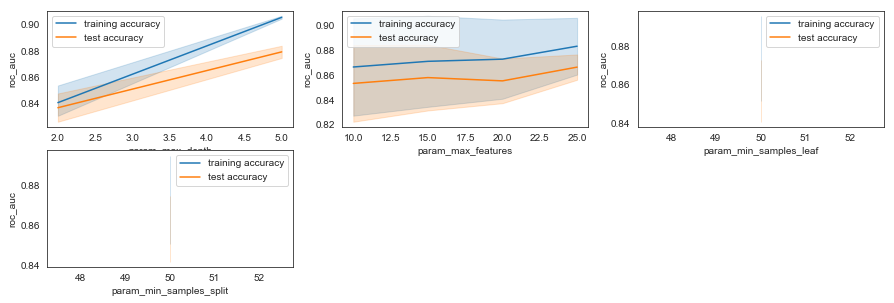

In [168]:
para_list=["param_max_depth","param_max_features","param_min_samples_leaf","param_min_samples_split"]

plot_gridSearch_para(df_scores, para_list, "roc_auc")

<font color=red size=3>__Optimising DecisionTree Model Parameters__</font>

In [171]:
model_dt_nor1 = DecisionTreeClassifier(max_depth=5, max_features=10,
                                      min_samples_leaf=50, min_samples_split=50)
model_dt_nor1.fit(X_train.values.tolist(), y_train.values.tolist())

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.086781  1.000000     0.000000   0.086781
0.1   0.1  0.881135  0.639605     0.904087   0.387891
0.2   0.2  0.914314  0.565551     0.947456   0.505640
0.3   0.3  0.922359  0.526604     0.959967   0.555556
0.4   0.4  0.926358  0.481075     0.968672   0.593369
0.5   0.5  0.929928  0.288535     0.990878   0.750357
0.6   0.6  0.929071  0.252880     0.993328   0.782683
0.7   0.7  0.925977  0.174986     0.997342   0.862162
0.8   0.8  0.922978  0.125617     0.998749   0.905138
0.9   0.9  0.920360  0.089962     0.999270   0.921348


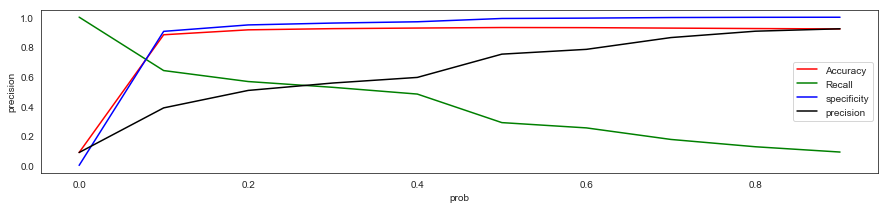

In [172]:
df_pred=predict_with_prob(model_dt_nor1,y_train,X_train)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [178]:
predict_score(model_dt_nor1, y_train, X_train, .04)

Accuracy:	 0.4940258009235017
Recall:  	 0.8464070213933077
Specificity:	 0.4605400333611343
Precision:	 0.12975109317188024
Confusion Matrix:
 [[ 8835 10349]
 [  280  1543]]


In [179]:
predict_score(model_dt_nor1, y_test, X_test, .04)

Accuracy:	 0.4971123944913372
Recall:  	 0.8571428571428571
Specificity:	 0.4634442555258684
Precision:	 0.12997243009058684
Confusion Matrix:
 [[3816 4418]
 [ 110  660]]


<font color=red size=3>__Visualize Decision Tree__</font>

C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


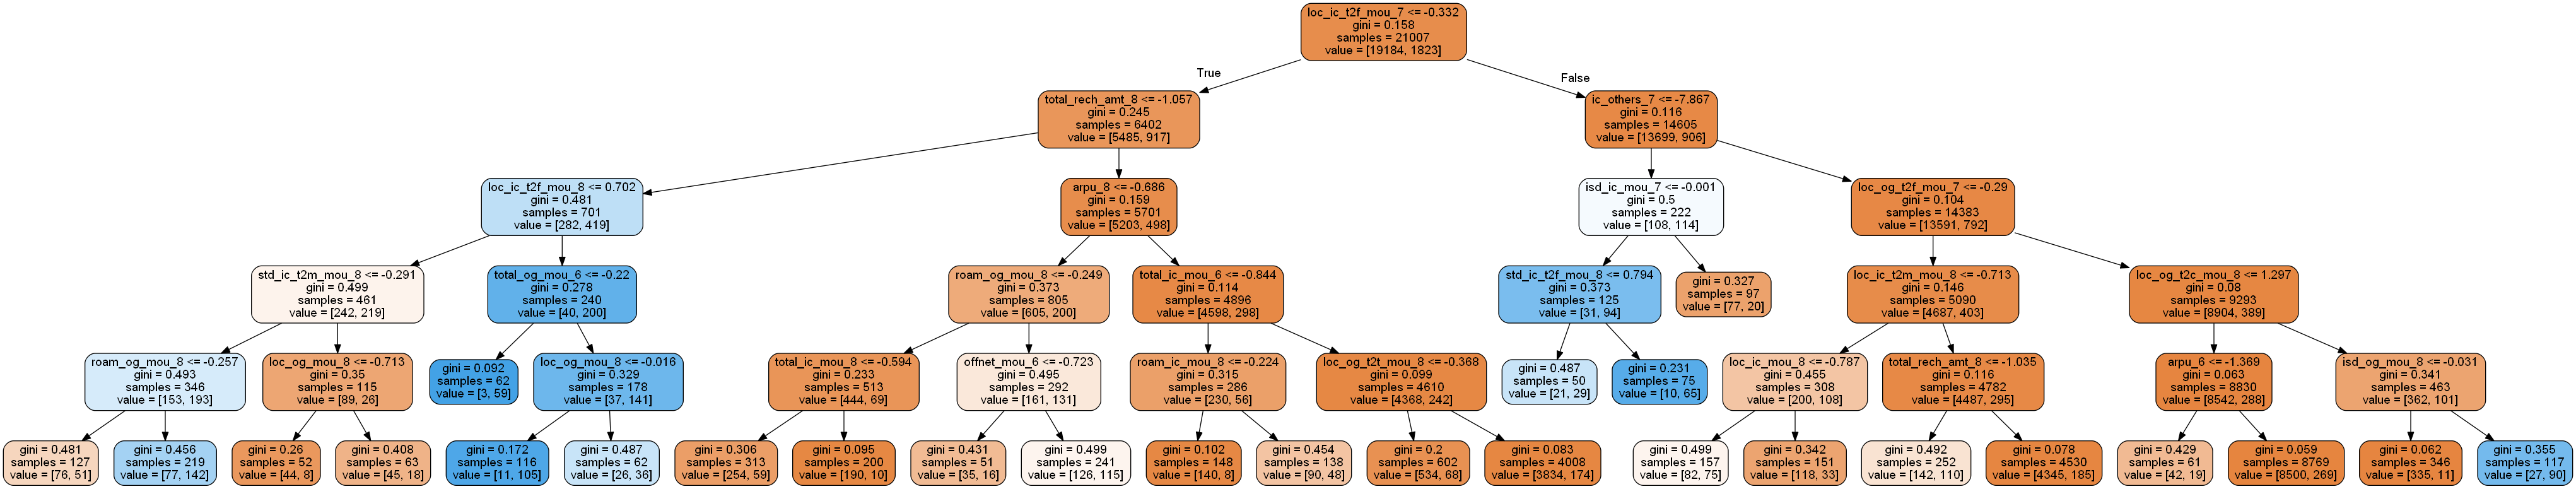

In [180]:
# Importing required packages for visualization
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus
import pydotplus.graphviz
features = list(X_train.columns[0:])
features

# plotting tree with max_depth=3
dot_data = StringIO()  
export_graphviz(model_dt_nor1, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

<font color=red size=6>__Check the Feature Importance__</font>

In [181]:
df_features = pd.DataFrame({"feature":X_train.columns, "coef":model_rfc_nor1.feature_importances_})
df_features.sort_values("coef", ascending=False)

,feature,coef
14,roam_og_mou_8,0.125687
51,total_og_mou_8,0.115862
78,total_ic_mou_8,0.094041
11,roam_ic_mou_8,0.068872
63,loc_ic_mou_8,0.064997
87,total_rech_amt_8,0.062267
2,arpu_8,0.055826
29,loc_og_mou_8,0.032025
57,loc_ic_t2m_mou_8,0.031714
20,loc_og_t2m_mou_8,0.029547
